In [178]:
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as patches
from datetime import datetime
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

In [179]:
df = pd.read_csv('/content/transactional-sample.csv')
df.head()
#Normalize the data
def normalize(df):
    return (df - df.mean()) / df.std()

df = df[['card_number', 'transaction_date', 'transaction_amount', 'has_cbk',]]

#Having merchant and user id was only getting more false positives.
card_numbers_to_idx = { v:k for k,v in enumerate(np.unique(df['card_number'].values))}
df['card_number'].replace(card_numbers_to_idx, inplace=True)
df['card_number'] = normalize(df['card_number'])

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_date'] = normalize(df['transaction_date'])

df['transaction_amount'] = normalize(df['transaction_amount'])



df.replace({'No': 0, 'Yes': 1}, inplace=True)
data = df.values



In [180]:
class LogisticRegressionModel():
    def __init__(self):
        self.n_estimators = 500
        self.model = LogisticRegression()

    def train(self, train):
        train = asarray(train)
        X_train, y_train = train[:, :-1], train[:, -1].astype(int)
        self.model.fit(X_train, y_train)
        self.n_estimators += 500

    def predict(self, test):
        test = np.array(test).reshape(1, -1)
        yhat_prob = self.model.predict_proba(test)[0]
        threshold = 0.3
        prediction = 1 if yhat_prob[1] >= threshold else 0
        return prediction


In [181]:
logistic_regression = LogisticRegressionModel()

In [182]:
def get_models():
    models = []
    models.append(('logistic_regression', logistic_regression))
    return models

In [183]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [184]:
def training(data, n_test, n_models):
    preds = [list() for a in range(n_models)]
    train, test = train_test_split(data, n_test)

    history = [x for x in train]

    for i in range(len(test)):
        X_test, y_test = test[i, :-1], test[i, -1]
        models = get_models()
        for j, (name, model) in enumerate(models):
            model.train(history)
            y_hat = model.predict(X_test)
            preds[j].append(y_hat)
            if(i % 2 == 0):
                print('i:{:3d}, Model:{:13s}, Expected:{:.1f}, Predicted:{:.1f}'
                      .format(i, name, y_test, y_hat))

        history.append(test[i])

    errors = [list() for a in range(n_models)]
    for i, error in enumerate(errors):
        errors[i] = mean_absolute_error(test[:, -1], preds[i])
    return errors, test[:, -1], preds


In [185]:

# Training and evaluation
n_test = 700  # Number of test samples
n_models = 1  # Number of models


errors, actual_values, predictions = training(data, n_test, n_models)

# Print model statistics
for i, (name, _) in enumerate(get_models()):
    print(f"Model: {name}")
    print("Errors:", errors)
    print("Type of errors:", type(errors))
    print()



i:  0, Model:logistic_regression, Expected:0.0, Predicted:0.0
i:  2, Model:logistic_regression, Expected:0.0, Predicted:0.0
i:  4, Model:logistic_regression, Expected:0.0, Predicted:0.0
i:  6, Model:logistic_regression, Expected:0.0, Predicted:0.0
i:  8, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 10, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 12, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 14, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 16, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 18, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 20, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 22, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 24, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 26, Model:logistic_regression, Expected:0.0, Predicted:1.0
i: 28, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 30, Model:logistic_regression, Expected:0.0, Predicted:0.0
i: 32, M

In [186]:
payload = {
    "transaction_id" : 2342357,
    "merchant_id" : 29744,
    "user_id" : 97051,
    "card_number" : "434505******9116",
    "transaction_date" : "2019-11-30T23:16:32.812632",
    "transaction_amount" : 1993,
    "device_id" : 285475
}

def normalize_payload(payload, df):

    payload_df = pd.DataFrame(payload, index=[0])

    card_numbers_to_idx = {v: k for k, v in enumerate(np.unique(payload_df['card_number'].values))}
    payload_df['card_number'].replace(card_numbers_to_idx, inplace=True)
    card_numbers_to_idx2 = {v: k for k, v in enumerate(np.unique(df['card_number'].values))}
    df['card_number'].replace(card_numbers_to_idx2, inplace=True)

    payload_df['card_number'] = (payload_df['card_number'] - df['card_number'].mean()) / df['card_number'].std()

    payload_df['transaction_date'] = pd.to_datetime(payload_df['transaction_date'])
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    payload_df['transaction_amount'] = (payload_df['transaction_amount'] - df['transaction_amount'].mean()) / df['transaction_amount'].std()

    payload_df['transaction_date'] = (payload_df['transaction_date'] - df['transaction_date'].mean()) / df['transaction_date'].std()

    return payload_df

df2 = pd.read_csv('/content/transactional-sample.csv')


# Extract relevant columns from payload
payload2 = {key: payload[key] for key in ['card_number', 'transaction_date', 'transaction_amount']}

# Normalize payload
normalized_payload = normalize_payload(payload2, df2)
print(normalized_payload)

for index, row in normalized_payload.iterrows():
    X = row[:].values.reshape(1, -1)
    prediction = logistic_regression.predict(X)
    prediction = int(prediction)
    print(f"Row {index+1} - Prediction: {prediction}")

if(prediction == 0):
    print({"transaction_id": payload["transaction_id"],
           "recommendation": "approve"})

if(prediction == 1):
    print({"transaction_id": payload["transaction_id"],
           "recommendation": "deny"})

   card_number  transaction_date  transaction_amount
0    -1.717973           1.11817            1.378015
Row 1 - Prediction: 1
{'transaction_id': 2342357, 'recommendation': 'deny'}


In [187]:
# Iterate over the data and make predictions
all_predictions = []

for row in data:
    X = row[:-1].reshape(1, -1)
    prediction = logistic_regression.predict(X)
    all_predictions.append(prediction)
    has_cbk = row[-1]
    has_cbk = int(has_cbk)
    prediction = int(prediction)
    print(f"Row {i+1} - Prediction: {prediction}, has_cbk: {has_cbk}")
    i += 1



predictions_df = pd.DataFrame(all_predictions, columns=["Prediction"])


Row 1 - Prediction: 0, has_cbk: 0
Row 2 - Prediction: 0, has_cbk: 1
Row 3 - Prediction: 0, has_cbk: 0
Row 4 - Prediction: 1, has_cbk: 1
Row 5 - Prediction: 0, has_cbk: 0
Row 6 - Prediction: 0, has_cbk: 0
Row 7 - Prediction: 0, has_cbk: 0
Row 8 - Prediction: 0, has_cbk: 1
Row 9 - Prediction: 0, has_cbk: 1
Row 10 - Prediction: 0, has_cbk: 1
Row 11 - Prediction: 0, has_cbk: 0
Row 12 - Prediction: 0, has_cbk: 0
Row 13 - Prediction: 0, has_cbk: 0
Row 14 - Prediction: 0, has_cbk: 1
Row 15 - Prediction: 0, has_cbk: 0
Row 16 - Prediction: 0, has_cbk: 0
Row 17 - Prediction: 0, has_cbk: 0
Row 18 - Prediction: 0, has_cbk: 0
Row 19 - Prediction: 0, has_cbk: 0
Row 20 - Prediction: 0, has_cbk: 0
Row 21 - Prediction: 0, has_cbk: 0
Row 22 - Prediction: 0, has_cbk: 0
Row 23 - Prediction: 0, has_cbk: 0
Row 24 - Prediction: 0, has_cbk: 0
Row 25 - Prediction: 0, has_cbk: 0
Row 26 - Prediction: 1, has_cbk: 0
Row 27 - Prediction: 1, has_cbk: 1
Row 28 - Prediction: 0, has_cbk: 0
Row 29 - Prediction: 1, has_c

Cross-Validation Scores: [0.8703125  0.8703125  0.8796875  0.88125    0.87793427]
Mean Accuracy: 0.8758993544600939


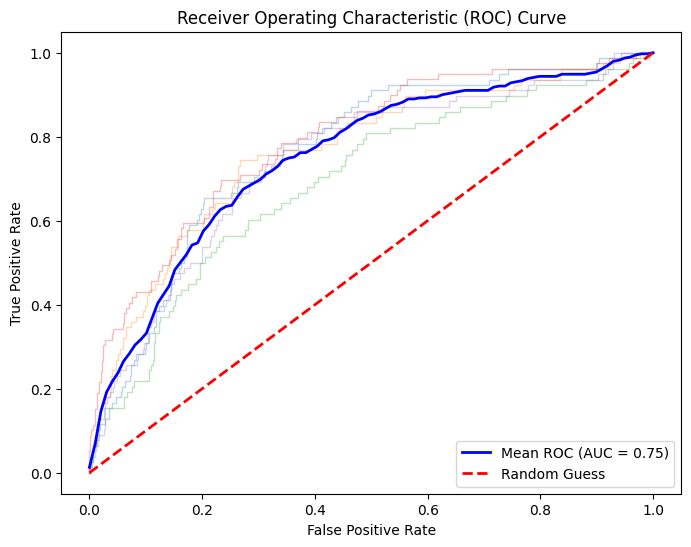

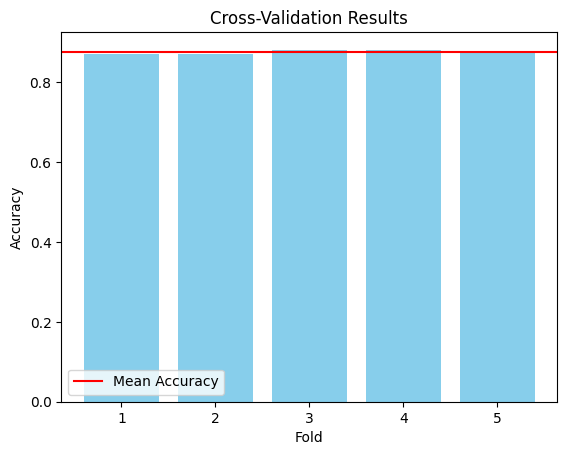

In [193]:
X = data[:, :-1]
y = data[:, -1].astype(int)

n_splits = 5

scores = cross_val_score(logistic_regression.model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))

tprs = []
fprs = []
aucs = []

plt.figure(figsize=(8, 6))

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    logistic_regression.train(np.column_stack((X_train, y_train)))

    # Get predicted probabilities for positive class (class 1)
    y_prob = logistic_regression.model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3)

    # Store tpr, fpr, and auc for later use
    tprs.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
    fprs.append(fpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess')

#roc curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#crossvalidation results
plt.bar(np.arange(1, n_splits + 1), scores, color='skyblue')
plt.axhline(y=np.mean(scores), color='r', linestyle='-', label='Mean Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Results')
plt.xticks(range(1, n_splits + 1))
plt.legend()
plt.show()